In [2]:
import bisect
from dataclasses import *

import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

<br>

# Different approaches to inference
---

You got a list of data points $x_n$ grouped inside a **design matrix** $X$ where each row is data point. We suppose that these data points are generated by a **model** of the form $p(x|\theta)$. We want to make new predictions for these data points $x$.

<br>

### Maximum Likelihood (ML) approach

One approach is the **maximum likelihood** approach, and consists in doing a **point estimate** $\theta_\text{ML}$ of the parameter $\theta$ and use it for future predictions. If we further assume that each points are independent, we have:

&emsp; $\theta_\text{ML} = \underset{\theta}{\text{argmax}} p(X|\theta) = \underset{\theta}{\text{argmax}} \prod_n p(x_n|\theta)$

Since the *max* and *log* distribute (they can interchange positions, because *log* is strictly monotonous), we usually transform our products into sum, and instead try to maximize the **log likelihood** of the data $X$ given the parameter $\theta$:

&emsp; $\theta_\text{ML} = \underset{\theta}{\text{argmax}} \sum_n \log p(x_n|\theta)$

We then do our estimations for future $x$ using this point estimate $\theta_\text{ML}$ using the formula $p(x|\theta_\text{ML})$. This approach is crude, but corresponds to what Machine Learning approach like Neural Networks do, when no **regularisation** is being used.

<br>

### Maximum A Posteriori (MAP) approach

The maximum likelihood approach makes the fundamental *error* of assuming than maximizing $p(X|\theta)$ is the same as maximizing $p(\theta|X)$. These two quantities are different but related by the same Bayes' theorem:

&emsp; $p(\theta|X) = \frac{p(X|\theta) p(\theta)}{p(X)} \propto p(X|\theta) p(\theta)$

The idea is therefore to maximize this quantity to get a point estimate of $\theta$:

&emsp; $\theta_\text{MAP} = \underset{\theta}{\text{argmax}} p(X|\theta) p(\theta)$

Once again, we turn to the assumption of independent samples $x_n$ and use *log* to break down the product into a summation. Our goal becomes to maximize the **log a posteriori probability**:

&emsp; $\theta_\text{MAP} = \underset{\theta}{\text{argmax}} \log p(\theta) + \sum_n \log p(x_n|\theta)$

If all $\theta$ are equality likely, this is equivalent to the maximum likelihood approach. This approach was therefore not completely flawed, but relied on the important assumption that all $\theta$s were equally likely.

<br>

### Critics of point estimates

The fondamental problem of the approaches above is that they produce a point estimate for the parameter $\theta^*$ of the distribution $p(x|\theta)$, dropping a lot of information on the way.

In general, the approaches above will at best give us the **mode** of the probability distribution $p(\theta|X)$. The mode is not even the **expected value** of the parameter $\theta$ of $p(\theta|X)$. And for some distributions, for instance a mixture of gaussian, the expected value is not that useful statistics.

Even we assume the distribution $p(\theta|X)$ is gaussian, for each the *mode* is equal to the *mean*, we still drop valuable information. For instance, we drop the variance for a gaussian distribution (which with the *mean* are **sufficent statistics** for a gaussian).

In general, we drop information that could be very useful, especially when combined with **utility theory** (some event might be unlikely but might be very important in weights).

<br>

### Bayesian approach

The Bayesian approach consists in simply applying the product and sum rules consistently, and avoid point estimators:

* $\mathcal{P}(X,Y|H) = \mathcal{P}(X|Y,H)\mathcal{P}(Y|H)$ (product rule)
* $\mathcal{P}(X|H) = \int \mathcal{P}(X,Y|H)dY$ (sum rule, marginalizing)

So, to do an estimation, the Bayesian approach to inference is to take into account the probability of each value of the parameters $\theta$ to make predictions. Practically, it means **marginalizing over $\theta$** to make predictions.

&emsp; $p(x|X) = \int p(x,\theta|X) d\theta = \int p(x|\theta) p(\theta|X) d\theta$

Using the Bayes' theorem, we end up with the following formula:

&emsp; $p(x|X) = \int p(x|\theta) \frac{p(X|\theta)}{p(X)} p(\theta) d\theta$, where $p(X) = \int p(X|\theta) p(\theta) d\theta$ is the normalization constant

Bayesian inference does not try to make point estimates of the parameters but look at the **whole probability distribution over the parameters** to make predictions. As such, it is much less suceptible to **overfitting the parameters**, but is also much harder to compute.

<br>

### Critics on priors

One of the typical critics for the Bayesian approach is to require **priors** on the parameters (or on any quantity required to apply the Bayes' theorem). The typical answer is that in order to make any predictions, we always need to make some assumptions.

We can list some of the assumptions we made above:

* We assumed the model to take the form $p(x|\theta)$: this assumption is there for any approach
* We assumed the data set is made of identically and independent samples, the **i.i.d. assumption**
* We assumed the prior to take the form $p(\theta)$: this assumption is done but for the ML approach

In practice, most models make assumptions on the **priors**. For example, **weight decay** $\lambda$ in Neural Network is equivalent to assuming that the parameters follow a gaussian prior centered on zero with precision $\lambda$: $p(\theta) = \mathcal{N}(\theta|0,\lambda^{-1})$.

In practice, all models make **assumptions** on the type of solution $p(x|\theta)$. The shape of a Neural Network dictates the types of functions it can approximate and the **invariance** it can express. For instance:

* CNN are all about a specific type of spacial invariance
* RNN are all about a specific type of time invariance

In addition to that, avoiding assumtions leads to creating models that are **needlessly generic** and therefore requires more training data, more training time, and are more prone to **overfitting**. Avoiding assumptions also means not being able to incorporate **expert knowledge** although this is what we do everyday as humans.

Of course, the risk of any assumption is for it to be wrong, and we must take care of revising these assumptions if needs be. The good thing is that as more data comes, **priors that are non-zeros tend to vanish** as evidence accumulates.

<br>

# Example 1: online reviews
---

How would you compare 2 online products, one with a 10/10 stars review, the other with a 45/50 stars review?

First some assumptions: we will not be taking into account the fact that a lot of products with few ratings might have fake ratings, and instead assume that all ratings are independant and identically distributed.

Also, our model will be that all products are the same, and have the same **satisfaction factor $s$**: the probability that a customer is satisified by the product is equal to $p(S) = s$ where $S$ stands for *satisfied*.

This is important to realize this is an important assumption, and we could have decided for other models:

* satisfaction could decrease with time (if innovation on a field is high)
* all products might not be manufactured the same (example for microprocessors)

The goal to select the product which has the highest change to satisfy us.

<br>

### Maximum Likelihood (ML) approach

We observe $k$ posivite among $n$ ratings. The probability to observe this data knowing $s$ is equal to:

&emsp; $p(D|s) = \binom{n}{k} s^k (1-s)^{n-k}$

Because:

* There are $\binom{n}{k}$ combinations of $k$ positive reviews among $n$
* For a given sequence $p (x_1, ..., x_n) = s^k (1-s)^{n-k}$ by i.i.d.

Applying the maximum log likelihood, and looking for the critical points by setting derivative to zero, we have:

&emsp; $\log p(D|s) = k \log s + (n - k) \log (1 - s) + constant$

&emsp; $\nabla_s \log p(D|s) = \frac{k}{s} + \frac{n-k}{s-1} = 0 \implies \frac{s}{1-s} = \frac{k}{n-k} \implies s = \frac{k}{n}$

The maximum likelihood therefore tells us to believe that the actual satisfaction level is equal to the ratio of stars we see in the reviews, whatever the number of reviews there is. This is clearly not in tune with our intuition.

<br>

### Confidence Interval

Once a point estimate $\theta^*$ has been done, we might be interested in **characterizing the uncertainty of the estimate**. Ideally, we would like to try different estimates around $\theta^*$ and verify how well they agree with the data we observe. This is in tune with what the Bayesian approach would do.

The frequentist approach is quite different, and consist in taking our point estimate $\theta^*$, generate new data with it, and check how many times it gives rise to the kind of data we observed (in our case, $k$ posivite votes among $n$).

We then look at the $5^{th}$ and $95^{th}$ percentiles (for instance) of the **cumulative density function (CDF)** and report the parameters at which these percentiles are crossed. The CDF is defined as:

&emsp; $CDF(k) = p(\text{up to k positive reviews among n} | \theta) = \sum_{i=0}^k p(\text{i positive reviews among n} | \theta)$

We show below the confidence interval for 40 positives among 50 reviews, for the Maximum Likelihood point estimate $s=\frac{k}{n}=0.8$

Confidence Interval = [0.7,0.88]


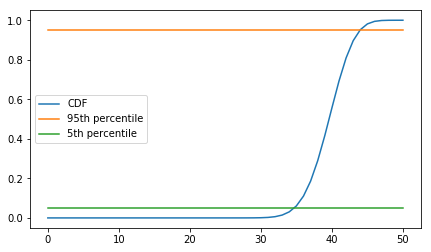

In [95]:
def combi(k, n):
    numerator = 1
    for i in range(n-k+1, n+1):
        numerator *= i
    denominator = 1
    for i in range(1, k+1):
        denominator *= i
    return numerator // denominator


def likelihood(s: float, stars: int, reviews: int):
    return combi(stars, reviews) * s ** stars * (1 - s) ** (reviews - stars)


stars = 40
reviews = 50
ml_point_estimate = stars / reviews

cumulative_densities = [likelihood(ml_point_estimate, 0, reviews)]
for stars in range(1, reviews+1):
    cumulative_densities.append(cumulative_densities[-1] + likelihood(ml_point_estimate, stars, reviews))

lo = bisect.bisect_left(cumulative_densities, 0.05)
hi = bisect.bisect_left(cumulative_densities, 0.95)
print('Confidence Interval = [{0},{1}]'.format(lo/reviews, hi/reviews))
    
plt.figure(figsize=(7,4))
plt.plot(cumulative_densities, label='CDF')
plt.plot([0.95] * len(cumulative_densities), label='95th percentile')
plt.plot([0.05] * len(cumulative_densities), label='5th percentile')
plt.legend()
plt.show()

**Beware:** A confidence interval of 0.7 to 0.88 does not mean that there is a 90% chance that the value of the parameter is between 0.7 and 0.88. You need Bayesian approach to make that kind of claims. The confidence interval tells you how reliable the estimate would change if you ran the same experiment again, using the point estimate the generate the data.

<br>

### Maximum A Posteriori (MAP) approach

In this approach, we can add some *priors* on the real value of $s$. For instance, we could look at the overall rating of the vendors (for all their products) and estimate that this represent the overall quality of their work.

For instance, if a vendor as a typical rating of $\mu$ with variance $\sigma^2$, we can approximate this using a Gaussian prior:

&emsp; $p(s) = \mathcal{N}(s|\mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp(- \frac{(s - \mu)^2}{2 \sigma^2})$

The overall probability becomes:

&emsp; $p(s|D) \propto p(D|s) p(s) = \binom{n}{k} s^k (1-s)^{n-k} \exp(- \frac{(s - \mu)^2}{2 \sigma^2})$

Which we can plot below for the following vendor:

* typical average rating of 3.4/5
* typical standard deviation of 0.2 stars

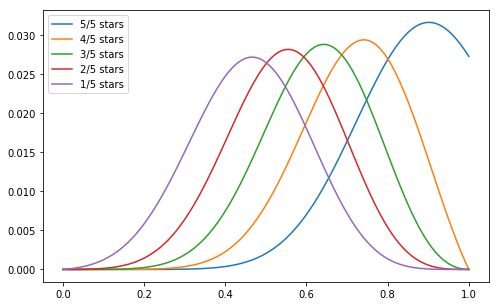

In [45]:
def rate(stars: int, reviews: int, vendor_rating: float, vendor_rating_deviation: float, s):
    sigma2 = vendor_rating_deviation ** 2
    prior = np.exp(- (s - vendor_rating) ** 2 / (2 * sigma2)) / math.sqrt(2 * math.pi * sigma2)
    likelihood = combi(stars, reviews) * s ** stars * (1 - s) ** (reviews - stars)
    results = likelihood * prior
    return results / np.sum(results)

    
vendor_data = dict(vendor_rating=3.4/5, vendor_rating_deviation=0.2)

plt.figure(figsize=(8,5))
parameters = np.arange(0.0, 1.01, 0.01)
plt.plot(parameters, rate(stars=5, reviews=5, **vendor_data, s=parameters), label='5/5 stars')
plt.plot(parameters, rate(stars=4, reviews=5, **vendor_data, s=parameters), label='4/5 stars')
plt.plot(parameters, rate(stars=3, reviews=5, **vendor_data, s=parameters), label='3/5 stars')
plt.plot(parameters, rate(stars=2, reviews=5, **vendor_data, s=parameters), label='2/5 stars')
plt.plot(parameters, rate(stars=1, reviews=5, **vendor_data, s=parameters), label='1/5 stars')
plt.legend()
plt.show()

We can see that the prior goes away with the increase of **evidence** on the quality of the product. Here we have the same kind of ratios, but scale down with more reviews.

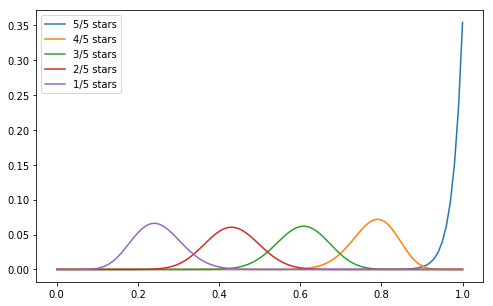

In [46]:
plt.figure(figsize=(8,5))
parameters = np.arange(0.0, 1.01, 0.01)
plt.plot(parameters, rate(stars=50, reviews=50, **vendor_data, s=parameters), label='5/5 stars')
plt.plot(parameters, rate(stars=40, reviews=50, **vendor_data, s=parameters), label='4/5 stars')
plt.plot(parameters, rate(stars=30, reviews=50, **vendor_data, s=parameters), label='3/5 stars')
plt.plot(parameters, rate(stars=20, reviews=50, **vendor_data, s=parameters), label='2/5 stars')
plt.plot(parameters, rate(stars=10, reviews=50, **vendor_data, s=parameters), label='1/5 stars')
plt.legend()
plt.show()

Using these graphs, we can solve the problem visually. To get an exact formula, we have to find a **closed form**. To do so, although we could manage to do it with gaussian priors, we will have a look at **conjugate priors**.

<br>

### Conjugate priors

For each distribution modeling the **likelihood**, we designate as **conjugate prior** a distribution such that when we multiply the likelihood with the prior, we get something of the form of the prior again (there could be several).

The conjugate prior of the **binomial** distribution is the **beta** distribution, equal to:

&emsp; $p(s) = \frac{1}{\text{Beta}(\alpha, \beta)} s^{\alpha-1} (1-s)^{\beta-1}$ where $\text{Beta}(\alpha,\beta) = \int_0^1 t^{\alpha-1} (1-t)^{\beta-1} dt$ is the normalizing constant

Indeed, if we multiply $p(D|s)$, which follows a binomial distribution, with the beta distribution, we get:

&emsp; $p(s|D) \propto s^{k+\alpha-1} (1-s)^{n-k+\beta-1} \implies p(s|D) = \frac{1}{\text{Beta}(k+\alpha, n-k+\beta)} s^{k+\alpha-1} (1-s)^{n-k+\beta-1}$

Which is equivalent to **modifying our knowledge based on new evidences**. This is a very interesting property that allows to use **online** rather than **batch** learning methods, in which we update our priors as new information comes. It also helps us in several other aspects:

* to get closed form solution to our equations
* to get automatically the normalizing constant

If we look more precisely at the Beta distribution, it has some interesting proprieties that connects it with the binomial distribution:

&emsp; $\text{Beta}(\alpha,\beta) = \frac{\Gamma(x)\Gamma(y)}{\Gamma(x+y)}$ looks like $\binom{x+y}{x}^{-1} = \frac{x!y!}{(x+y)!}$, where $\Gamma(x) = (x-1)!$ generalizes factorial on complex numbers

* Adding a new evidence for positive rating acts like adding +1 to $\alpha$
* Adding a new evidence for negative rating acts like adding +1 to $\beta$
* Having $\alpha=1$ and $\beta=1$ in the equation is having a uniform prior
* Having $\alpha=2$ and $\beta=2$ in the equation centers it more on $p=0.5$

The quantity $K=\alpha + \beta$ is the *concentration* of the the Beta distribution, and indicates how the probability distribution is centered on the *mode* of the distribution. We can have a look at this graphically.

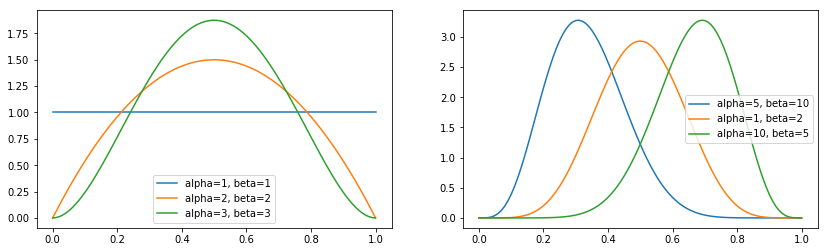

In [76]:
def beta(alpha: int, beta: int, p: float):
    return combi(alpha-1, alpha+beta-2) * (alpha+beta-1) * p ** (alpha - 1) * (1 - p) ** (beta - 1)


_, ax = plt.subplots(figsize=(14,4), ncols=2)
xs = np.arange(0., 1.01, 0.01)
ax[0].plot(xs, beta(1, 1, xs), label='alpha=1, beta=1')
ax[0].plot(xs, beta(2, 2, xs), label='alpha=2, beta=2')
ax[0].plot(xs, beta(3, 3, xs), label='alpha=3, beta=3')
ax[0].legend()
ax[1].plot(xs, beta(5, 10, xs), label='alpha=5, beta=10')
ax[1].plot(xs, beta(7, 7, xs), label='alpha=1, beta=2')
ax[1].plot(xs, beta(10, 5, xs), label='alpha=10, beta=5')
ax[1].legend()
plt.show()

<br>

### Solving MAP with conjugate priors

As seen above, using a Beta distribution as a uniform prior, we have:

&emsp; $p(s|D) = \frac{1}{\text{Beta}(k+\alpha, n-k+\beta)} s^{k+\alpha-1} (1-s)^{n-k+\beta-1}$

To maximize the log of the probability, we set the derivative with respect to $s$ to zero:

&emsp; $\log p(s|D) = (k + \alpha - 1) \log s + (n - k + \beta - 1) \log (1 - s) + constant$

&emsp; $\nabla_s \log p(s|D) = \frac{k+\alpha-1}{s} + \frac{n-k+\beta-1}{s-1} = 0 \implies s = \frac{k+\alpha-1}{n+\alpha+\beta-2}$

So in case we have a uniform prior ($\alpha=1$ and $\beta=1$), we fall back on $s = \frac{k}{n}$.

If we believe that our vendor has, in average 3.5/5 stars, we can set prior in different ways:

* $\alpha=3.5$ and $\beta=1.5$ (for 3.5 satisfied clients, and 1.5 disatisfied clients)
* $\alpha=7$ and $\beta=3$ (same prior, but twice as strong in intensity)

We could also set these priors based on our previous appreciation of other products we bought from the respective vendors. In any case, we end up with the formula $s = \frac{k+\alpha-1}{n+\alpha+\beta-2}$.

<br>

### Laplace's rule of succession

The previous approach consisted in looking for the **mode** of the *a posteriori* distribution. This approach is sensible in case the mode coincides with the **expected value**. This is the case for the Gaussian distribution, but this is not the case of the Beta distribution.

The expected value of the beta distribution is equal to $\mathcal{E}[s] = \frac{\alpha}{\alpha+\beta}$ while the mode is equal to $\mathcal{M}[s] = \frac{\alpha-1}{\alpha+\beta-2}$. In our case, it means that if we assume a prior $\alpha=\alpha_0$ and $\beta=\beta_0$, then our posterior distribution has the form of a Beta distribution with parameters:

* $\alpha_n=k+\alpha_0$
* $\beta_n=n-k+\beta_0$.

Our best guess (the expected value) is therefore equal to $s = \frac{k+\alpha}{n+\alpha+\beta}$, which for a uniform prior gives us $s = \frac{k+1}{n+2}$.

This is called **Laplace's rule of succession**: not knowing anything about the vendor of the product (uniform prior), the best evaluation for $s$ is done by doing as if there was 2 additional votes: 1 positive and 1 negative, and then take the usual Maximum Likelihood approach, the ratio of positive to negative, to evaluate $s$.

<br>

### Bayesian approach

Laplace's rule of succession is in fact a Bayesian approach applied for the binomial distribution with its conjugate prior, the Beta distribution, taken as a uniform prior. To see this, let us look at the Bayesian approach:

&emsp; $p(S=s|D) = \int p(s|\theta) p(\theta|D) d\theta$

If we apply this with our binomial distribution, where $\theta$ is the satisfaction factor, $S$ is the boolean random variable that represents the satisfaction, and with the Beta distribution as conjugate prior, we get:

&emsp; $p(s|\theta)= \theta$ (we have $\theta$ probability of being satisfied)

&emsp; $p(\theta|D) = \frac{1}{\text{Beta}(k+\alpha, n-k+\beta)} \theta^{k+\alpha-1} (1-\theta)^{n-k+\beta-1}$

&emsp; $p(s|D) = \int \theta p(\theta|D) d\theta = E[\theta]$

So we fall back on the general version of the Laplace's rule of succession.

<br>

# Example 2: guessing the number of train
---

We observe trains on the road and look at their numbers. We observe this as a sequence $x=(x_1,...,x_n)$. We have to guess how many trains there are in total, assuming that all trains have consecutive numbers.

Our model will assume that all train are equally likely to be observed (uniform distribution) parameterized by $N$, the maximum number of trains:

&emsp; $p(k|N) = \frac{1}{N}$ where $k$ is the number observed

Clearly, $N$ has to be equal or higher than the numbers of the trains observed, but how much?

<br>

### Maximum Likelihood (ML) approach

The probability of observing the specific sequence of observation $(x_1,..., x_n)$ is equal to $\frac{1}{N^n}$. The probability of observing the unordered sequence of numbers $(x_1,..., x_k)$ with multiplicity $(c_1, ..., c_k)$ is equal to: $\frac{1}{N^n} \frac{n!}{c_1! \times ... \times c_k!}$.

This is a specific case of the multinomial distribution:

&emsp; $p(D|N) = p(x_1,...,x_k,c_1,...c_k|N) = p_1^{c_1} ... p_k^{c_k} \frac{n!}{c_1! \times ... \times c_k!} = \frac{1}{N^n} \frac{n!}{c_1! \times ... \times c_k!}$

This multinomial distribution is used to estimate the probability of having differents counts of different values. This is not what we are interested in here. Plus the only change in our case is the additional combinatorial factors. So we will use the following:

&emsp; $p(D|N) = p(x_1,..., x_n|N) = \frac{1}{N^n}$

Now, if we want to maximize the probability of the data $D$ knowing $N$, the best thing we can do is minimize $N$, with $N$ bigger than the maximum value of $x_n$. Our best point estimate is: $N = \underset{i}{\text{max}} (x_i)$, which is not quite what we would expect intuitively.

<br>

### Maximum Likelihood (ML) approach (2)

Another approach that leads at the same result, is to minimize the negative log likelihood $E$, where $E$ stands for error:

&emsp; $E = - \log p(D|N) = n \log N + constant$

With the constraint that $N >= \underset{i}{\text{max}} (x_i)$. We can do this by introducing a Langrangian:

&emsp; $\mathcal{L}(N,\alpha) = n \log N - \alpha (N-\underset{i}{\text{max}} (x_i))$, with $\alpha \geq 0$

We seek the critical point that make the gradient being null $\nabla \mathcal{L} = (\mathcal{L}_N, \mathcal{L}_\alpha) = 0$:

&emsp; $\mathcal{L}_N = \frac{n}{N} - \alpha = 0 \implies \alpha \ne 0 \implies \text{the constraint is active} \implies \mathcal{L}_\alpha = 0$

&emsp; $\mathcal{L}_\alpha = N-\underset{i}{\text{max}} (x_i) = 0 \implies N = \underset{i}{\text{max}} (x_i)$

We get the same conclusion as before, only through a more convoluted way.

In [122]:
from scipy.optimize import minimize, Bounds

xs = np.array([4, 2, 5, 9])
bounds = Bounds([np.max(xs)], [np.inf])

def neg_log_likelihood(N):
    return len(xs) * math.log(N)

res = minimize(neg_log_likelihood, 2*N, method='trust-constr', bounds=bounds)
print("Best value:", res.x[0])

Best value: 9.001802818288748


<br>

### Maximum A Posteriori (MAP) approach

To play with the MAP approach, we need to define a *prior* on $N$. There are many choices here. We could define a uniform prior but that would require us to choose an arbitrary upper bound (which we could still choose based on knowledge), but uniform prior might not be the best choice.

Intuitively, there are more chances that a company has fewer train than a high number of train: if we never see a number higher than 10, we would be more confortable guessing 100 trains than guessing 500 trains, even if the upper bound is 1000.

If we assume that having 200 trains, is 4 times as unlikely as having 100 trains, then the *a priori* distribution will look like: $p(N) \propto \frac{1}{N^2}$. This is a specific case of the power-law distribution (check http://www.piketty.pse.ens.fr/files/powerlaws80-20rule.pdf):

&emsp; $p(N) \propto (\frac{1}{N})^{\alpha}$, where $\alpha > 1$ for the normalization factor (integral) to be defined

Now we can apply the Bayes' theorem to get:

&emsp; $p(N|D) \propto p(D|N)p(N) = \frac{1}{N^n} \frac{1}{N^\alpha} = \frac{1}{N^{n+\alpha}}$

The maximization of this quantity still leads to the same conclusion as ML approaches: $N = \underset{i}{\text{max}} (x_i)$.

<br>

### Conjugate priors

We can also approach the problem of selecting a prior by using the **conjugate prior** of the uniform distribution, which is equal to the Pareto distribution:

&emsp; $p(x) = \frac {\alpha x_{\mathrm {m} }^{\alpha }}{x^{\alpha +1}} \implies p(N) \propto \frac{1}{N^{\alpha+1}}$, with $\alpha > 0$

As for all conjugate prior, adding one evidence $\frac{1}{N}$ returns a prior of the same form, with modified parameters. In that case, it is equivalent to adding 1 to $\alpha$. The **pareto distribution** is somehow equivalent to having more evidence. 

* https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions.
* https://en.wikipedia.org/wiki/Pareto_distribution

<br>

### Bayesian error estimation

The Bayesian approach is about keeping the whole estimation of $p(N|D)$ and not simply keeping a point estimate $N^*$. This would for example allow us to infer new train numbers using the following formula:

&emsp; $p(\text{train number} = k|D) = \sum_{N=\text{max} x_i}^\infty p(k|N) p(N|D)$

But this is not what we are interested in our case. In our example, our interest is in making the best guess. What "best" means actually depends on how we evaluate our guessing error, through an **error function** (a specific case of **utility function** when applied in that case).

&emsp; $\text{Error}(\text{Guess} = g) = \sum_{N=\text{max} x_i}^\infty \text{Error}(g|N) p(N|D)$

Different choices of error function will lead to different results. As an exemple, if the goal is to maximize the chance of being exactly right, then our error measure will be, and minimizing the error will force same conclusion as before:

&emsp; $\text{Error}(\text{Guess} = g) = \sum_{N=\text{max} x_i}^\infty (1 - \delta_{g=N}) p(N|D) = 1 - p(g|D) = 1 - \frac{1}{g^n}$

But there are different choices of errors, for instance the **mean square error**. In that case, it turns out that the answer will be the **expected value** of N instead of the **mode** of N (which is what ML approach will always return):

&emsp; $\text{Error}(\text{Guess} = g) = \sum_{N=\text{max} x_i}^\infty (g - N)^2 p(N|D)$

&emsp; $\nabla_g \text{Error} = 2 \sum_{N=\text{max} x_i}^\infty (g - N) p(N|D) = 0$

Note that this is not obvious that you can switch the infinite sum with the integral ([example for integrals](https://en.wikipedia.org/wiki/Leibniz_integral_rule#General_form:_Differentiation_under_the_integral_sign)). Now we can develop this and we find the the expected value minimizes this error:

&emsp; $g \sum_N p(N|D) = \sum_N N p(N|D) \implies g = \sum_N N p(N|D) = \text{E}[N|D]$

&emsp; $g = \text{E}[N|D] \propto \sum_N \frac{1}{N^{n+\alpha-1}}$, which converges if $\alpha > 1$ if we have at least one data point ($n \geq 1$)

We can experimentally compute this sum by stopping at a high enough $N$.

In [154]:
def estimate_train(xs: np.ndarray, alpha: float) -> float:
    n_obs = len(xs)
    lower_N = np.max(xs)
    upper_N = lower_N * 1000 + 1
    
    def term(N: int) -> float:
        return 1 / N ** (n_obs + alpha)
    
    normalization = sum(term(N) for N in range(lower_N, upper_N))
    guess = sum(term(N) * N for N in range(lower_N, upper_N)) / normalization
    return round(guess)


# Alpha: 4 times less chance to have 2 times more trains
print("Guess:", estimate_train([9], alpha=2.))
print("Guess:", estimate_train([4, 9], alpha=2.))
print("Guess:", estimate_train([4, 2, 5, 9], alpha=2.))

Guess: 17
Guess: 13
Guess: 11


<br>

# Example 3: The price is right
---

We are playing a two players game in which players are supposed to guess the price of an object. The one whose guess is the closest to the actual price wins the price, but there is a catch: if a player's guess is higher than the actual price, the player is disqualified and automatically loses.

To help us, we have watched a lot of times the show, and we have historical data regarding the usual prices of objects.

<br>

### Combining different sources of data

This example is made up to plunge into the notion of **utility theory** that we already briefly saw in the example above. To solve this game, we have to combine:

* Knowledge about past prices (*prior* on prices)
* Modelisation of this knowledge (**density estimation**)
* What we think the price is when we look at the object (first player)
* How to take into account the bid of the other player (second player)
* What is the expected return of a guess (utility)

We will start by fetching some historical prices data (we use another DB here):

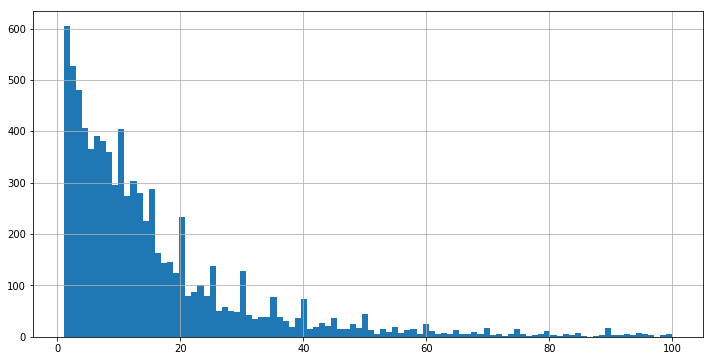

In [212]:
import pandas as pd

def clean_price(s):
    if isinstance(s, str):
        s = s[1:]
        try:
            s = s.split(' ')[0]
            return float(s)
        except ValueError as e:
            return np.nan
    else:
        return s

df = pd.read_csv('dataset/toy_price_samples.csv')
prices = df['price'].map(clean_price)
prices = prices[prices <= 100][prices >= 1]
plt.figure(figsize=(12,6))
prices.hist(bins=100)
plt.show()

<br>

### Modeling the Prior - Density Estimation

The problem with the historical data is that they do not allow us to work conveniently with them from a mathematical standpoint. We will therefore try to approximate them with a *model*. The process of parameterizing a model to represent a density is called **density estimation**.

A simple visualization of the histogram of prices above directs us toward a model that looks like [Pareto distribution](https://en.wikipedia.org/wiki/Pareto_distribution) (a.k.a. a power law). We will therefore parameterize of a model of the form :

&emsp; $p(P|\alpha) = \frac{\alpha M^\alpha}{P^{\alpha+1}}$, where $M = 1$ (the mode) and $\alpha > 0$

To do so, we will minimize the negative log likelihood of the data, which we will call our error:

&emsp; $\mathcal{E} = -\log \prod_n \frac{\alpha}{x_n^{\alpha + 1}} = \sum_n [(\alpha + 1) \log x_n - \log \alpha] = \alpha \sum_n \log x_n - N \log \alpha$

tensor(0.4375, requires_grad=True)


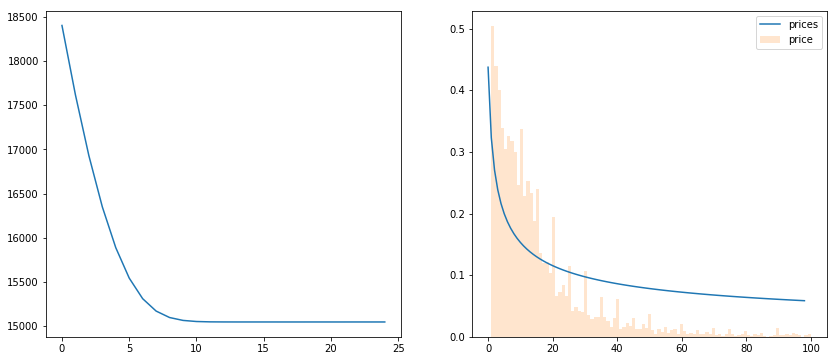

In [240]:
def train(parameters, cost_function):
    losses = []
    optimizer = optim.Adam(parameters)

    train_xs = data.TensorDataset(torch.FloatTensor(prices))
    train_loader = data.DataLoader(train_xs, shuffle=True, batch_size=100)
    for _ in range(25):
        episode_loss = 0.
        for x in train_loader:
            loss = cost_function(x[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            episode_loss += loss.item()
        losses.append(episode_loss)
    return losses


alpha = torch.tensor(1., requires_grad=True)

def nll_pareto(xs):
    return alpha * torch.sum(torch.log(xs)) - len(xs) * torch.log(alpha)

def pdf_pareto(xs):
    return alpha.item() / xs ** alpha.item()

losses = train([alpha], nll_pareto)
print(alpha)

_, ax = plt.subplots(figsize=(14,6), ncols=2)
ax[0].plot(losses, label='loss')
ax[1].plot([0] + pdf_pareto(np.arange(1, 100, 1)), label='prices')
ax[1].hist(prices, bins=100, alpha=0.2, weights=np.ones(len(prices)) / 1200)
plt.legend()
plt.show()

Since the Pareto distribution does not fit, we can try an exponential distribution: $p(x|\lambda) = \lambda e^{-\lambda x}$

&emsp; $\mathcal{E} = -\log \prod_n \lambda e^{-\lambda x_n} = \lambda \sum_n x_n - N \log \lambda$

0.06476563215255737


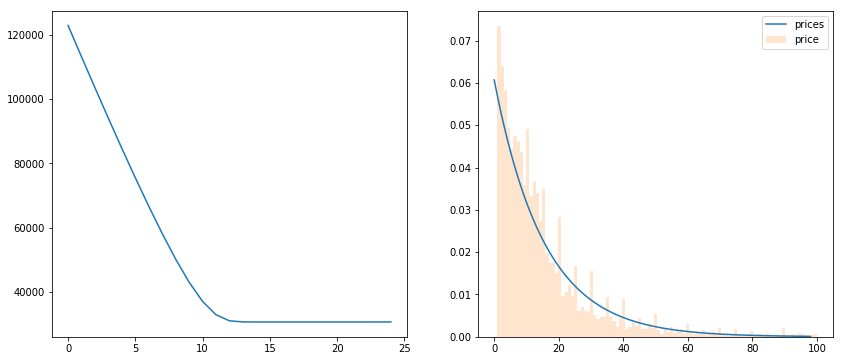

In [246]:
lam = torch.tensor(1., requires_grad=True)

def nll_exponential(xs):
    return lam * torch.sum(xs) - len(xs) * torch.log(lam)

def pdf_exponential(xs):
    return lam * np.exp(- lam * xs)

losses = train([lam], nll_exponential)
lam = lam.item()
print(lam)

_, ax = plt.subplots(figsize=(14,6), ncols=2)
ax[0].plot(losses, label='loss')
ax[1].plot(pdf_exponential(np.arange(1, 100, 1)), label='prices')
ax[1].hist(prices, bins=100, alpha=0.2, weights=np.ones(len(prices)) / len(prices))
plt.legend()
plt.show()

This one fits well, and we can there adopt the exponential distribution with parameter $\lambda = 0.065$.

<br>

### Guessing a price

We will note $R$ as the real price of the goods and $G$ is the price guessed by the player. $G$ is fixed, this is the intuition of the price that the candidate gets. $G$ **is the evidence**. We will assume that our candidates are pretty good and usually guess right.

We will model the candidate guess $G$ as a gaussian centered on the real price $R$ with a variance $\sigma^2$:

&emsp; $p(R|\lambda) = \lambda e^{-\lambda R}$

&emsp; $p(G|R) = \mathcal{N}(G|R,\sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(G - R)^2}{2 \sigma^2}}$

&emsp; $p(R|G) \propto p(G|R)p(R) = \frac{\lambda}{\sqrt{2 \pi \sigma^2}} e^{-\lambda R -\frac{1}{2 \sigma^2} (G - R)^2}$

$p(R|G)$ **represents the probability that the real price is $R$ knowing that the candidate intuitions tells him that the price should be** $G$. It is interesting to see that the candidate is in general not wise to bet what he/she thinks that is the right price.

This difference is illustrated below graphically: we see that the initial guess of the candidate is an evidence that modifies the most likely price distribution toward lower values (because of the *prior* on prices). 

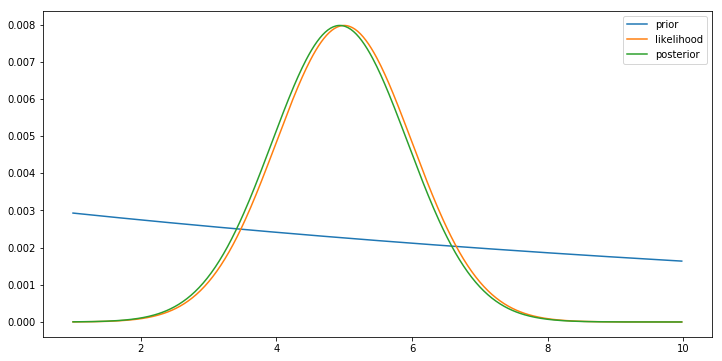

Guess G was: 5.0
Best R is: 4.940000000000003


In [309]:
def likelihood(G, R, sigma):
    return 1 / (np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(G-R)**2/(2*sigma**2))


def revise_guess(G: float, prior_distribution):
    plt.figure(figsize=(12,6))
    xs = np.arange(1., 10., 0.02)
    prior = prior_distribution(xs)
    like = likelihood(G, xs, 1.)
    post = like * prior
    plt.plot(xs, prior / np.sum(prior), label='prior')
    plt.plot(xs, like / np.sum(like), label='likelihood')
    plt.plot(xs, post / np.sum(post), label='posterior')
    plt.legend()
    plt.show()

    print("Guess G was:", G)
    print("Best R is:", xs[np.argmax(post)])
    

revise_guess(5., pdf_exponential)

We see that the prior modifies is the most likely price according to our guess (even if the *mode* of our guess was right), and therefore pushes us toward a different bet. This phenomenon would be more prononced if the prior had more differences, like the gaussian that follows.

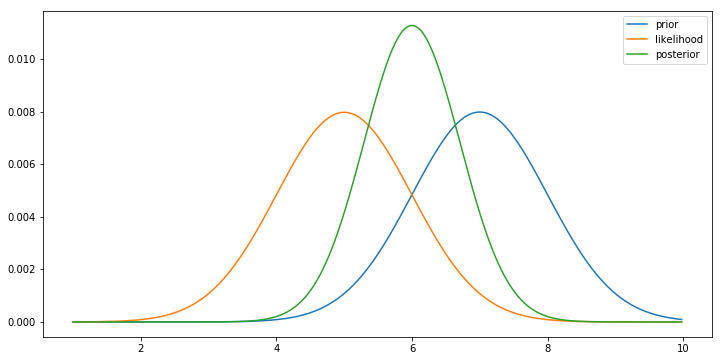

Guess G was: 5.0
Best R is: 6.000000000000004


In [310]:
def pdf_gaussian(loc, scale):
    def pdf(xs):
        return 1 / (np.sqrt(2 * np.pi * scale**2)) * np.exp(-(xs-loc)**2/(2*scale**2))
    return pdf
    

revise_guess(5., pdf_gaussian(7, 1))

<br>

### Maximizing gain

Maximizing the probability is not the same as maximizing gain, since outcomes have different **utility**. We want to make a bet $B$ (which is different form our initial guess $G$ and the real price $R$ which is unknown) that maximizes our returns.

Our return function $gain$ is a bit complex:

* If we guess higher than the real price, it is equal to zero
* If we guess closer to our opponent, we get the object, which is worth $R$
* If our opponent is closer, it is equal to zero again (too low)

**We therefore have to model our opponent**: we will estimate that our opponent has a guess $G'$, and computes its posterior distribution $p(R|G')$ the same way we did. We will look at his posterior distribution to estimate the probability that his/her bet is better than ours.

Best bet: 8.55
Best bet: 8.250000000000002
Best bet: 7.25


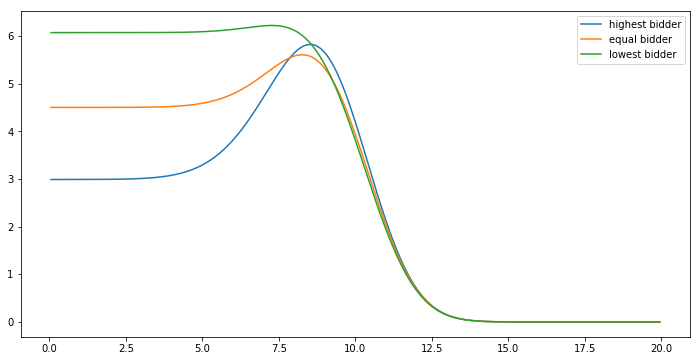

Best bet: 8.500000000000002
Best bet: 8.500000000000002
Best bet: 8.500000000000002


In [ ]:
def estimate_gain(guess: float, opponent_guess: float,
                  opponent_knows: bool = False,
                  prior_distribution=pdf_exponential):   
    """
    For each possible bid, estimate the gain that the player would make if:
    * the player initially thinks the price of his goods is 'guess'
    * the opponent initially thinks the price of his goods is 'opponent_guess'
    
    BEWARE: assumes that:
    1) we 'know' what our opponent really think is the price (our initial guess)
    2) he does not 'know' what we really think is the price (our initial guess)
    IF BOTH KNOW, both will play the same
    """
    
    # All the price values we consider, with prior probabilities
    delta = 0.05
    xs = np.arange(delta, 20., delta)
    prior = prior_distribution(xs)
    prior /= np.sum(prior)

    # Compute the posterior probability for both the player and the opponent
    posterior = prior * likelihood(guess, xs, 2.)
    posterior /= np.sum(posterior)
    posterior_opponent = prior * likelihood(opponent_guess, xs, 2.)
    posterior_opponent /= np.sum(posterior_opponent)
    cum_posterior_opponent = np.cumsum(posterior_opponent)
    
    # Compute the real posterior of the data (given the two independent indices on the price)
    real_posterior = posterior * posterior_opponent
    real_posterior /= np.sum(real_posterior)
    if opponent_knows:
        cum_posterior_opponent = np.cumsum(real_posterior)
    
    # Return the probability that the opponent bids is between our value and the true value
    def prob_opponent_between(bid: float, price: float) -> float:
        lo = bisect.bisect_left(xs, bid)
        hi = bisect.bisect_left(xs, price)
        return cum_posterior_opponent[hi] - cum_posterior_opponent[lo]
    
    # We win if we do not overbid and if the opponent bid is less than ours (further away)
    def gain_of(bid: float, price: float) -> float:
        if bid > price:
            return 0.
        else:
            p_opponent_wins = prob_opponent_between(bid, price)
            return price * (1 - p_opponent_wins)
    
    # Compute the expected gain of a given bid
    def gain_of_bid(bid: float) -> float:
        return sum(prob * gain_of(bid, price) for price, prob in zip(xs, real_posterior))
    
    gains = [gain_of_bid(bid) for bid in xs]
    print("Best bet:", xs[np.argmax(gains)])
    return xs, gains


prior = pdf_exponential
# prior = pdf_gaussian(10, 4)

for opponent_knows in (False, True):
    plt.figure(figsize=(12,6))
    plt.plot(*estimate_gain(11., 9., opponent_knows, prior), label='highest bidder')
    plt.plot(*estimate_gain(10., 10., opponent_knows, prior), label='equal bidder')
    plt.plot(*estimate_gain(9., 11., opponent_knows, prior), label='lowest bidder')
    plt.legend()
    plt.show()

<br>

# Example 4: Estimating the bus waiting time
---

We know that the bus is passing every 10 minutes. When coming to the bus station, some passengers already present, and we can use this information to decude the remaining time for the bus.

<br>

### Exponential & Poisson distribution

The **exponential distribution** models the probability of **time between events** (here the arrival of passengers) of a **Poisson process**, i.e. if these events occur with a known constant mean rate and independently of the time since the last event.

&emsp; $p(t|\lambda) = \lambda e^{-\lambda t}$, where $\lambda$ is the mean time between events

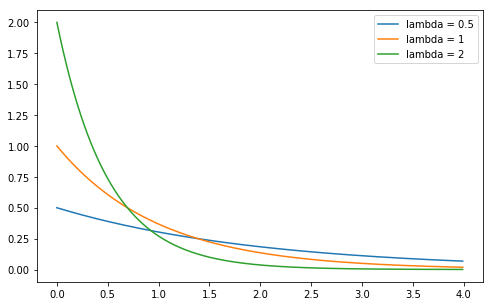

In [10]:
def exp_distribution(lam, xs):
    return lam * np.exp(- lam * xs)

xs = np.arange(0., 4., 0.01)
plt.figure(figsize=(8,5))
plt.plot(xs, exp_distribution(0.5, xs), label='lambda = 0.5')
plt.plot(xs, exp_distribution(1.0, xs), label='lambda = 1')
plt.plot(xs, exp_distribution(2.0, xs), label='lambda = 2')
plt.legend()
plt.show()

The **poisson distribution** is the discrete probability distribution of the **number of events for a given unit of time**.

&emsp; $p(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$, where $\lambda$ is the average number of events

&emsp; $p(k|r,t) = \frac{(rt)^k e^{-rt}}{k!}$, where $r$ is the rate of arrival and $t$ the time interval

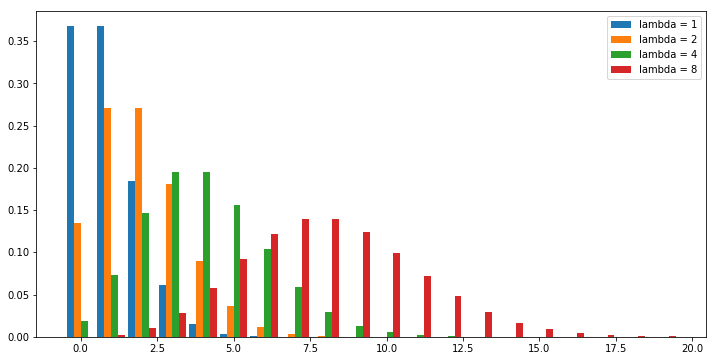

In [34]:
def factorial(k):
    n = 1
    for i in range(1, k+1):
        n *= i
    return n

def poisson_distribution(lam, ks):
    return [lam ** k * np.exp(-lam) / factorial(k) for k in ks]

xs = np.arange(0, 20, 1)
plt.figure(figsize=(12,6))
width = 0.9 / 4
plt.bar(xs - 1.5 * width, poisson_distribution(1.0, xs), width, label='lambda = 1')
plt.bar(xs - 0.5 *width, poisson_distribution(2.0, xs), width, label='lambda = 2')
plt.bar(xs + 0.5 * width, poisson_distribution(4.0, xs), width, label='lambda = 4')
plt.bar(xs + 1.5 * width, poisson_distribution(8.0, xs), width, label='lambda = 8')
plt.legend()
plt.show()